<a href="https://colab.research.google.com/github/VavRe/nndl-ut/blob/main/CA6/NNDL_HW6_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,ReLU,Reshape
from keras.utils import plot_model
from keras.constraints import Constraint
from keras.optimizers import RMSprop


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Dataset

In [ ]:
images = []
classes = []
for (root,dirs,files) in os.walk('/content/drive/MyDrive/NNDL-UT/HW6/Dataset', topdown=True):
  for filename in files:
    images.append(cv2.imread(os.path.join(root, filename)))
    classes.append(int(root.split('/')[-1][-1]))
images = np.array(tf.image.resize((np.array(images).astype('float32') - 127.5) / 127.5, (64,64)))
classes = keras.utils.to_categorical(np.array(classes) - 1)

In [ ]:
images.shape, classes.shape

((1005, 64, 64, 3), (1005, 5))

<Figure size 720x720 with 0 Axes>

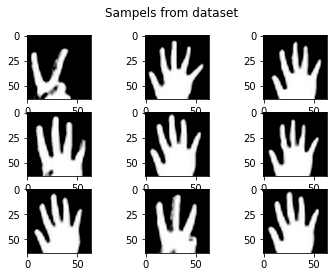

In [ ]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(3, 3)
fig.suptitle('Sampels from dataset')
for i in range(3):
  for j in range(3):
    idx = np.random.randint(len(images))
    ax[i,j].imshow(images[idx])


# Critic

In [ ]:
from keras import backend
 
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
 return backend.mean(y_true * y_pred)


In [ ]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
 # set clip value when initialized
 def __init__(self, clip_value):
  self.clip_value = clip_value
 
 # clip model weights to hypercube
 def __call__(self, weights):
  return backend.clip(weights, -self.clip_value, self.clip_value)
 
 # get the config
 def get_config(self):
  return {'clip_value': self.clip_value}


In [ ]:
ki = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)    # Wheights initialized using a zero-centered Gaussian distribution

In [ ]:
# define the constraint
constraint = ClipConstraint(0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


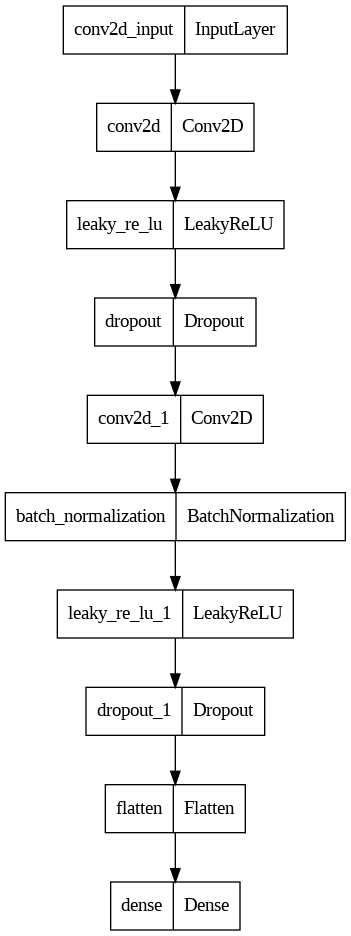

In [ ]:
def critic_model():
  
  
  critic = Sequential([
      
      Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=ki, input_shape=[64,64, 3], kernel_constraint=constraint),    # No BatchNormilization in this layer
      LeakyReLU(alpha=0.2),
      Dropout(0.4),

      Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=ki, kernel_constraint=constraint),
      BatchNormalization(),
      LeakyReLU(alpha=0.2),
      Dropout(0.4),

      Flatten(),
      Dense(1, activation='linear', kernel_initializer=ki)
  ])

  opt = RMSprop(lr=0.00005)
  critic.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
 
  return critic

d_model = critic_model()
d_model.summary()
plot_model(d_model)

# Generator

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2097408   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)     

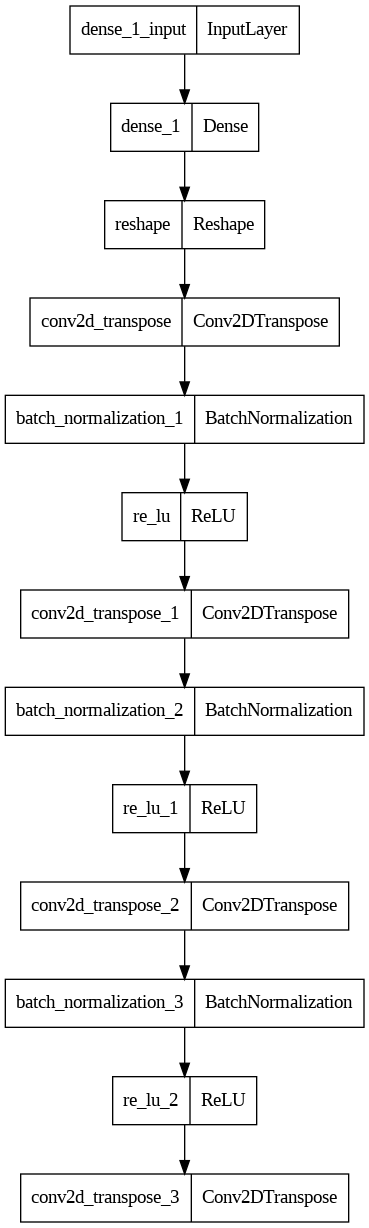

In [ ]:
noise_shape = 100

def generator_model():
  
  generator = Sequential([
      
      Dense(4*4*512, input_shape=[noise_shape], kernel_initializer=ki),
      Reshape([4,4,512]),

      Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", kernel_initializer= ki),
      BatchNormalization(),
      ReLU(),

      Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_initializer=ki),
      BatchNormalization(),
      ReLU(),
      
      Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", kernel_initializer=ki),
      BatchNormalization(),
      ReLU(),
      
      Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", kernel_initializer=ki, activation='tanh') # 3 filters, also no BatchNormilization in this layer
  ])

  # opt = RMSprop(lr=0.00005)
  # generator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return generator

g_model = generator_model()
g_model.summary()
plot_model(g_model)

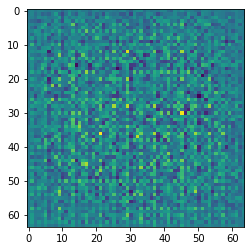

In [ ]:
noise = tf.random.normal([1,100])
generated_image = g_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

# Combining

In [ ]:
base_path = '/content/drive/MyDrive/NNDL-UT/HW6/results/WGAN/'
def save_plot(examples, epoch, n=10):

	for i in range(n * n):

		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0])

	filename = f'{base_path}generated_plot_e{epoch+1}.png' 
	plt.savefig(filename)
	plt.close()


In [ ]:
def define_gan(g_model, d_model):

	d_model.trainable = False       # critic is not trained here.
	model = Sequential()
	model.add(g_model)
	model.add(d_model)

	opt = RMSprop(lr=0.00005)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):

	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]  																									# Selecting random samples from images.
	y = -np.ones((n_samples, 1))
  
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):

	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
 
	return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):

	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)																			# Fake samples are made using generator.
	y = np.ones((n_samples, 1))
 
	return X, y

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)

In [ ]:
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	plt.plot(d1_hist, label='crit_real')
	plt.plot(d2_hist, label='crit_fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	plt.savefig('plot_line_plot_loss.png')
	plt.close()

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128, n_critic=5):

	gen_acc, critic_real_acc = list(), list()
	gen_loss, critic_real_losses = list(), list()
	critic_fake_losses = list()
 
	bat_per_epo = dataset.shape[0] // n_batch
	half_batch = n_batch // 2

	for i in range(n_epochs):
		for j in range(bat_per_epo):

			for _ in range(n_critic):

				X_real, y_real = generate_real_samples(dataset, half_batch)
				X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
				critic_real_loss, critic_real_acc = d_model.train_on_batch(X_real, y_real)                     # Train critic
				critic_fake_loss, critic_fake_acc = d_model.train_on_batch(X_fake, y_fake)                     # Train critic

				critic_real_losses.append(critic_real_loss)
				critic_fake_losses.append(critic_fake_loss)

			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))                                    # When training generator, fake samples are labeled 1
	 
			g_loss, g_acc = gan_model.train_on_batch(X_gan, y_gan)           # Training Generator
			gen_loss.append(g_loss)
			gen_acc.append(g_acc)

			print('Epoch %d - Batch %d/%d:\n  Loss fake: d=%.3f, g=%.3f\n  Loss real: d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, critic_fake_loss, g_loss, critic_real_loss, g_acc))
			# evaluate the model performance, sometimes

			if (i+1) % 5 == 0:
				summarize_performance(i, g_model, d_model, dataset, latent_dim)
	return gen_acc, critic_real_losses, gen_loss, critic_fake_losses

In [ ]:
g_model = generator_model()
d_model = critic_model()
gan_model = define_gan(g_model, d_model)
dataset = images
latent_dim = 100

In [ ]:
gen_acc, critic_real_losses, gen_loss, critic_fake_losses = train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 10ms/step
Epoch 137 - Batch 5/7:
  Loss fake: d=-1425.808, g=0.000
  Loss real: d=-3070.845, g=1.000
2/2 [==============================] - 0s 16ms/step
Epoch 137 - Batch 6/7:
  Loss fake: d=-1415.388, g=0.121
  Loss real: d=-3095.709, g=0.992
2/2 [==============================] - 0s 8ms/step
Epoch 137 - Batch 7/7:
  Loss fake: d=-1438.087, g=0.121
  Loss real: d=-3022.736, g=0.992
2/2 [==============================] - 0s 14ms/step
Epoch 138 - Batch 1/7:
  Loss fake: d=-1437.429, g=0.000
  Loss real: d=-3081.805, g=1.000
2/2 [==============================] - 0s 10ms/step
Epoch 138 - Batch 2/7:
  Loss fake: d=-1433.451, g=0.121
  Loss real: d=-3019.480, g=0.992
2/2 [==============================] - 0s 11ms/step
Epoch 138 - Batch 3/7:
  Loss fake: d=-1444.902, g=0.000
  Loss real: d=-3044.610, g=1.000
2/2 [==============================] - 0s 9ms/step
Epoch 138 - Batch 4/7:
  Loss fake: d=-14

In [ ]:
plt.plot(gen_acc, label='Gen. Acc.')
plt.plot(gen_loss, label='Gen. Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(critic_real_losses, label='critic. Real Loss.')
plt.plot(critic_fake_losses, label='critic. Fake Loss')
plt.legend()
plt.show()

NameError: ignored